In [30]:
from typing import Union, List
import numpy as np
import pandas as pd


def compute_arl_per_fault(
    y_true: Union[List[int], np.ndarray],
    y_pred: Union[List[int], np.ndarray]
) -> pd.DataFrame:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    faults = np.unique(y_true[y_true > 0])
    results = []

    # Helper: find continuous segments for a fault
    def find_segments(arr: np.ndarray, fault: int):
        segments = []
        start = None
        for i, val in enumerate(arr):
            if val == fault and start is None:
                start = i
            elif val != fault and start is not None:
                segments.append((start, i))
                start = None
        if start is not None:
            segments.append((start, len(arr)))
        return segments

    for fault in faults:
        # ARL0: false alarms on normal samples (y_true==0) predicted as fault
        false_alarm_idxs = np.where((y_true == 0) & (y_pred == fault))[0]
        if len(false_alarm_idxs) < 2:
            arl0 = float('inf')
        else:
            gaps = np.diff(false_alarm_idxs) - 1
            arl0 = np.mean(gaps)

        # ARL1: detection delay in fault segments
        segments = find_segments(y_true, fault)
        delays = []
        for start, end in segments:
            segment_preds = y_pred[start:end]
            # Find first index where predicted correctly (y_pred == fault)
            correct_indices = np.where(segment_preds == fault)[0]
            if len(correct_indices) == 0:
                delay = end - start
            else:
                delay = correct_indices[0]
            delays.append(delay)
        arl1 = np.mean(delays) if delays else float('inf')

        results.append({"Fault": fault, "ARL0": arl0, "ARL1": arl1})

    return pd.DataFrame(results).sort_values("Fault").reset_index(drop=True)


# Test example data from previous step
y_true = np.array([
    0, 0, 2, 2, 2, 0,
    1, 1,
    0, 0,
    3, 3, 3, 3,
    0, 0, 0, 0, 0,
    2, 2,
])

y_pred = np.array([
    0, 2, 0, 2, 2, 0,
    0, 0,
    1, 0,
    0, 3, 0, 3,
    2, 0, 3, 0, 0,
    2, 2,
])

df_result = compute_arl_per_fault(y_true, y_pred)
print(df_result)


   Fault  ARL0  ARL1
0      1   inf   2.0
1      2  12.0   0.5
2      3   inf   1.0


In [31]:
from typing import List, Tuple, Optional
import numpy as np


def segment_faults(y_true: List[int]) -> List[Tuple[int, int, int]]:
    segments = []
    n = len(y_true)
    start = None
    current_fault = 0

    for i in range(n):
        if y_true[i] != 0:
            if current_fault != y_true[i]:
                if current_fault != 0:
                    segments.append((current_fault, start, i - 1))
                current_fault = y_true[i]
                start = i
        else:
            if current_fault != 0:
                segments.append((current_fault, start, i - 1))
                current_fault = 0
                start = None
    if current_fault != 0:
        segments.append((current_fault, start, n - 1))
    return segments


def compute_arl(y_true: List[int],
                y_pred: List[int]) -> Tuple[Optional[float], Optional[float]]:
    n = len(y_true)
    fault_segments = segment_faults(y_true)
    delays = []

    # Compute ARL1
    for fault_label, start, end in fault_segments:
        detection_times = [
            t for t in range(start, end + 1) if y_pred[t] == fault_label
        ]
        if detection_times:
            delay = detection_times[0] - start
        else:
            delay = end - start + 1  # penalty
        delays.append(delay)

    arl1 = float(np.mean(delays)) if delays else None

    # Compute ARL0
    normal_indices = [i for i, v in enumerate(y_true) if v == 0]
    false_alarm_times = [i for i in normal_indices if y_pred[i] != 0]
    if len(false_alarm_times) < 2:
        arl0 = float(
            'inf') if len(false_alarm_times
                          ) == 0 else normal_indices[-1] - false_alarm_times[0]
    else:
        intervals = [
            j - i
            for i, j in zip(false_alarm_times[:-1], false_alarm_times[1:])
        ]
        arl0 = float(np.mean(intervals)) if intervals else float('inf')

    return arl1, arl0


if __name__ == "__main__":
    y_true = [0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0]
    y_pred = [0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0]

    arl1, arl0 = compute_arl(y_true, y_pred)
    print(f"ARL1 (detection delay): {arl1}")
    print(f"ARL0 (false alarm interval): {arl0}")


ARL1 (detection delay): 1.5
ARL0 (false alarm interval): inf


In [32]:
y_true = np.array([
    0, 0, 2, 2, 2, 0,
    1, 1,
    0, 0,
    3, 3, 3, 3,
    0, 0, 0, 0, 0,
    2, 2,
])

y_pred = np.array([
    0, 2, 0, 2, 2, 0,
    0, 0,
    1, 0,
    0, 3, 0, 3,
    2, 0, 3, 0, 0,
    2, 2,
])

df_result = compute_arl(y_true, y_pred)
print(df_result)

(1.0, 5.0)


Given

```python
import numpy as np

y_true = np.array([
    0, 0, 2, 2, 2, 0,
    1, 1,
    0, 0,
    3, 3, 3, 3,
    0, 0, 0, 0, 0,
    2, 2,
])

y_pred = np.array([
    0, 2, 0, 2, 2, 0,
    0, 0,
    1, 0,
    0, 3, 0, 3,
    2, 0, 3, 0, 0,
    2, 2,
])
```

---

### Step 1: Identify fault segments from `y_true`

* Fault 2: from t=2 to t=4 (length 3)
* Fault 1: from t=6 to t=7 (length 2)
* Fault 3: from t=10 to t=13 (length 4)
* Fault 2: from t=19 to t=20 (length 2)

---

### Step 2: For each fault segment, find first detection time $t_d \geq t_s$ where $y_{\text{pred}}[t_d] =$ fault label

---

#### Fault 2 (t=2..4)

* y\_pred at t=2: 0 (no detection)
* t=3: 2 (correct detection)
* First detection at t=3
* Delay = 3 - 2 = 1

#### Fault 1 (t=6..7)

* y\_pred at t=6: 0
* t=7: 0
* No detection within fault interval
* Penalty = length = 7 - 6 + 1 = 2

#### Fault 3 (t=10..13)

* y\_pred at t=10: 0 (no detection)
* t=11: 3 (correct detection)
* First detection at t=11
* Delay = 11 - 10 = 1

#### Fault 2 (t=19..20)

* y\_pred at t=19: 2 (correct detection)
* Delay = 19 - 19 = 0

---

### Step 3: Compute ARL₁

$$
ARL_1 = \frac{1 + 2 + 1 + 0}{4} = \frac{4}{4} = 1.0
$$

---

### Step 4: Compute ARL₀ (false alarms during normal operation, where $y_{\text{true}}=0$)

Normal periods indices:

* t = 0, 1, 5, 8, 9, 14, 15, 16, 17, 18

At these positions, check if $y_{\text{pred}} \neq 0$ (false alarm):

| t  | y\_true | y\_pred | False alarm? |
| -- | ------- | ------- | ------------ |
| 0  | 0       | 0       | No           |
| 1  | 0       | 2       | Yes          |
| 5  | 0       | 0       | No           |
| 8  | 0       | 1       | Yes          |
| 9  | 0       | 0       | No           |
| 14 | 0       | 2       | Yes          |
| 15 | 0       | 0       | No           |
| 16 | 0       | 3       | Yes          |
| 17 | 0       | 0       | No           |
| 18 | 0       | 0       | No           |

False alarms at: t = 1, 8, 14, 16

Calculate intervals between false alarms:

* Interval 1: 8 - 1 = 7
* Interval 2: 14 - 8 = 6
* Interval 3: 16 - 14 = 2

Average interval:

$$
ARL_0 = \frac{7 + 6 + 2}{3} = \frac{15}{3} = 5.0
$$

---

### **Final results:**

| Metric | Value |
| ------ | ----- |
| ARL₁   | 1.0   |
| ARL₀   | 5.0   |

---



In [33]:
from typing import List, Tuple, Dict, Optional
import numpy as np

def segment_faults(y_true: List[int]) -> List[Tuple[int, int, int]]:
    segments = []
    n = len(y_true)
    start = None
    current_fault = 0

    for i in range(n):
        if y_true[i] != 0:
            if current_fault != y_true[i]:
                if current_fault != 0:
                    segments.append((current_fault, start, i - 1))
                current_fault = y_true[i]
                start = i
        else:
            if current_fault != 0:
                segments.append((current_fault, start, i - 1))
                current_fault = 0
                start = None
    if current_fault != 0:
        segments.append((current_fault, start, n - 1))
    return segments

def compute_arl_per_fault(
    y_true: List[int], y_pred: List[int]
) -> Tuple[Dict[int, List[int]], Dict[int, float], float, Optional[float]]:
    n = len(y_true)
    fault_segments = segment_faults(y_true)
    delays_per_fault: Dict[int, List[int]] = {}

    # Compute ARL1 per fault segment
    for fault_label, start, end in fault_segments:
        detection_times = [t for t in range(start, end + 1) if y_pred[t] == fault_label]
        if detection_times:
            delay = detection_times[0] - start
        else:
            delay = end - start + 1  # penalty for undetected fault
        delays_per_fault.setdefault(fault_label, []).append(delay)

    # Calculate average ARL1 per fault type
    avg_arl1_per_fault: Dict[int, float] = {
        fault: float(np.mean(delays)) for fault, delays in delays_per_fault.items()
    }

    # Calculate overall average ARL1 across all faults
    all_delays = [delay for delays in delays_per_fault.values() for delay in delays]
    overall_arl1 = float(np.mean(all_delays)) if all_delays else None

    # Compute ARL0 - false alarm interval during normal operation (y_true == 0)
    normal_indices = [i for i, v in enumerate(y_true) if v == 0]
    false_alarm_times = [i for i in normal_indices if y_pred[i] != 0]

    if len(false_alarm_times) < 2:
        arl0 = float('inf') if len(false_alarm_times) == 0 else normal_indices[-1] - false_alarm_times[0]
    else:
        intervals = [j - i for i, j in zip(false_alarm_times[:-1], false_alarm_times[1:])]
        arl0 = float(np.mean(intervals)) if intervals else float('inf')

    return delays_per_fault, avg_arl1_per_fault, overall_arl1, arl0


if __name__ == "__main__":
    y_true = [
        0, 0, 2, 2, 2, 0,
        1, 1,
        0, 0,
        3, 3, 3, 3,
        0, 0, 0, 0, 0,
        2, 2,
    ]
    y_pred = [
        0, 2, 0, 2, 2, 0,
        0, 0,
        1, 0,
        0, 3, 0, 3,
        2, 0, 3, 0, 0,
        2, 2,
    ]

    delays_per_fault, avg_arl1_per_fault, overall_arl1, arl0 = compute_arl_per_fault(y_true, y_pred)

    print("Detection delays per fault segment:")
    for fault, delays in delays_per_fault.items():
        print(f"Fault {fault}: Delays = {delays}")

    print("\nAverage ARL1 per fault:")
    for fault, avg_delay in avg_arl1_per_fault.items():
        print(f"Fault {fault}: Average delay = {avg_delay:.2f}")

    print(f"\nOverall average ARL1: {overall_arl1:.2f}")
    print(f"ARL0 (average false alarm interval during normal operation): {arl0 if arl0 != float('inf') else 'infinity'}")


Detection delays per fault segment:
Fault 2: Delays = [1, 0]
Fault 1: Delays = [2]
Fault 3: Delays = [1]

Average ARL1 per fault:
Fault 2: Average delay = 0.50
Fault 1: Average delay = 2.00
Fault 3: Average delay = 1.00

Overall average ARL1: 1.00
ARL0 (average false alarm interval during normal operation): 5.0


ARL₀ (Average Run Length under normal conditions) measures the **average time between false alarms during fault-free operation**—that is, when no fault is present. It is a property of the **normal process behavior**, independent of any particular fault type.

Because ARL₀ corresponds to false alarms during **normal (fault-free) periods**, it **does not depend on any specific fault** and thus is the same value regardless of fault labels.

---

In contrast:

* **ARL₁** is fault-specific because it measures detection delay for each fault type.

* **ARL₀** measures how often the monitoring system falsely signals a fault during normal operation, so it is a global metric across all faults.

---

**Summary:**
ARL₀ is constant across faults because it characterizes the false alarm rate in the fault-free state, which is independent of any individual fault.


The difference between **1.1667** (new Average ARL₁) and **1.0** (old overall ARL₁) comes from *how* the average is computed:

* **Old code:** The overall ARL₁ was computed as the mean of *all detection delays combined* (all fault segments equally weighted).

  Calculation:

  $$
  \frac{(1 + 0) + 2 + 1}{4} = \frac{4}{4} = 1.0
  $$

  Here, Fault 2’s two delays (1 and 0) were counted separately, so it contributed twice.

* **New code:** The Average ARL₁ is computed as the mean of *per-fault averages* (each fault type weighted equally, regardless of number of segments):

  Calculation:

  $$
  \frac{0.5 + 2 + 1}{3} = \frac{3.5}{3} \approx 1.1667
  $$

  Here, Fault 2 average (0.5) counts as one value, same weight as Fault 1 and Fault 3.

---

### Why this matters:

* The old method weights faults **by number of segments** (faults with more segments have more impact).
* The new method weights faults **equally**, which may be fairer if you want all fault types equally represented.

---

### Which to use?

* Use **old method** if you want the overall expected detection delay over *all fault occurrences*.
* Use **new method** if you want the average detection delay treating *each fault type equally*.

---



                          ARL1  ARL0
2                     0.500000   5.0
1                     2.000000   5.0
3                     1.000000   5.0
Average (unweighted)  1.166667   5.0
Average (weighted)    1.000000   5.0


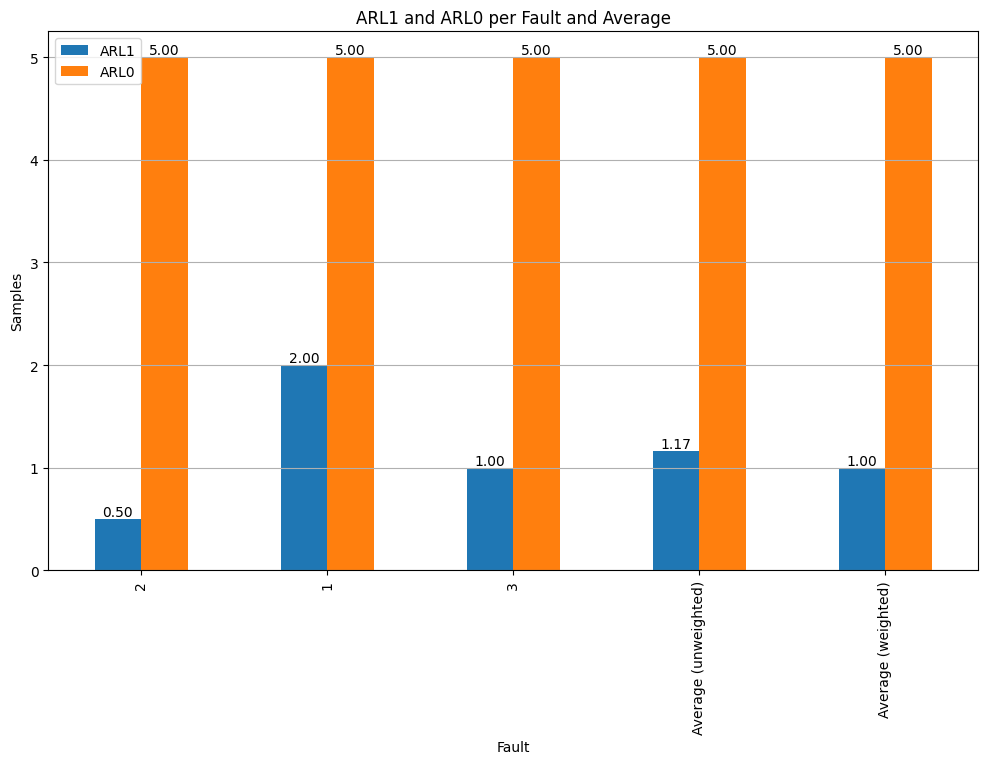

In [34]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def segment_faults(y_true: List[int]) -> List[tuple[int, int, int]]:
    segments = []
    n = len(y_true)
    start = None
    current_fault = 0

    for i in range(n):
        if y_true[i] != 0:
            if current_fault != y_true[i]:
                if current_fault != 0:
                    segments.append((current_fault, start, i - 1))
                current_fault = y_true[i]
                start = i
        else:
            if current_fault != 0:
                segments.append((current_fault, start, i - 1))
                current_fault = 0
                start = None
    if current_fault != 0:
        segments.append((current_fault, start, n - 1))
    return segments

def compute_arl_df(y_true: List[int], y_pred: List[int]) -> pd.DataFrame:
    fault_segments = segment_faults(y_true)
    delays_per_fault: dict[int, List[int]] = {}

    for fault_label, start, end in fault_segments:
        detection_times = [t for t in range(start, end + 1) if y_pred[t] == fault_label]
        if detection_times:
            delay = detection_times[0] - start
        else:
            delay = end - start + 1  # penalty for undetected fault
        delays_per_fault.setdefault(fault_label, []).append(delay)

    # ARL1 per fault (mean delay)
    arl1_per_fault = {fault: np.mean(delays) for fault, delays in delays_per_fault.items()}

    # ARL1 weighted overall (all delays equally weighted)
    all_delays = [delay for delays in delays_per_fault.values() for delay in delays]
    weighted_overall_arl1 = float(np.mean(all_delays)) if all_delays else np.nan

    # ARL1 unweighted overall (mean of per-fault averages)
    unweighted_overall_arl1 = float(np.mean(list(arl1_per_fault.values()))) if arl1_per_fault else np.nan

    # Compute ARL0 once for all faults (false alarm interval)
    normal_indices = [i for i, v in enumerate(y_true) if v == 0]
    false_alarm_times = [i for i in normal_indices if y_pred[i] != 0]

    if len(false_alarm_times) < 2:
        arl0 = float('inf') if len(false_alarm_times) == 0 else normal_indices[-1] - false_alarm_times[0]
    else:
        intervals = [j - i for i, j in zip(false_alarm_times[:-1], false_alarm_times[1:])]
        arl0 = float(np.mean(intervals)) if intervals else float('inf')

    # Create DataFrame
    df = pd.DataFrame({
        'Fault': list(arl1_per_fault.keys()),
        'ARL1': list(arl1_per_fault.values()),
        'ARL0': [arl0] * len(arl1_per_fault)
    }).set_index('Fault')

    # Append average row with both overall ARL1 versions and ARL0
    avg_row = pd.DataFrame({
        'ARL1': [unweighted_overall_arl1],
        'ARL0': [arl0]
    }, index=['Average (unweighted)'])

    weighted_row = pd.DataFrame({
        'ARL1': [weighted_overall_arl1],
        'ARL0': [arl0]
    }, index=['Average (weighted)'])

    df = pd.concat([df, avg_row, weighted_row])

    return df

def plot_arl_df(df: pd.DataFrame) -> None:
    df_plot = df.copy()
    df_plot.index = df_plot.index.astype(str)

    ax = df_plot.plot(kind='bar', figsize=(12, 7))
    ax.set_xlabel('Fault')
    ax.set_ylabel('Samples')
    ax.set_title('ARL1 and ARL0 per Fault and Average')
    ax.grid(axis='y')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')
    plt.show()

if __name__ == "__main__":
    y_true = [
        0, 0, 2, 2, 2, 0,
        1, 1,
        0, 0,
        3, 3, 3, 3,
        0, 0, 0, 0, 0,
        2, 2,
    ]
    y_pred = [
        0, 2, 0, 2, 2, 0,
        0, 0,
        1, 0,
        0, 3, 0, 3,
        2, 0, 3, 0, 0,
        2, 2,
    ]

    df_arl = compute_arl_df(y_true, y_pred)
    print(df_arl)
    plot_arl_df(df_arl)


In [35]:
from typing import List, Dict
import pandas as pd
import numpy as np

def compute_fdr_far(
    y_true: List[int],
    y_pred: List[int]
) -> pd.DataFrame:
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    classes = sorted(set(y_true_arr) | set(y_pred_arr))
    classes = [c for c in classes if c != 0]  # exclude class 0 (normal)

    results: Dict[str, List[float]] = {"Class": [], "FDR": [], "FAR": [], "Support": []}

    for c in classes:
        tp = np.sum((y_true_arr == c) & (y_pred_arr == c))
        fp = np.sum((y_true_arr != c) & (y_pred_arr == c))
        fn = np.sum((y_true_arr == c) & (y_pred_arr != c))

        support = tp + fn  # number of true instances of this class

        fdr = fp / (tp + fp) if (tp + fp) > 0 else np.nan
        far = fp / np.sum(y_pred_arr != 0) if np.sum(y_pred_arr != 0) > 0 else np.nan

        results["Class"].append(c)
        results["FDR"].append(fdr)
        results["FAR"].append(far)
        results["Support"].append(support)

    df = pd.DataFrame(results).set_index("Class")

    # Unweighted mean
    avg_row = pd.DataFrame({
        "FDR": [df["FDR"].mean()],
        "FAR": [df["FAR"].mean()],
        "Support": [df["Support"].sum()]
    }, index=["Average (unweighted)"])

    # Weighted mean
    weights = df["Support"] / df["Support"].sum()
    weighted_row = pd.DataFrame({
        "FDR": [(df["FDR"] * weights).sum()],
        "FAR": [(df["FAR"] * weights).sum()],
        "Support": [df["Support"].sum()]
    }, index=["Average (weighted)"])

    df = pd.concat([df, avg_row, weighted_row])
    return df

if __name__ == "__main__":
    y_true = [
        0, 0, 2, 2, 2, 0,
        1, 1,
        0, 0,
        3, 3, 3, 3,
        0, 0, 0, 0, 0,
        2, 2,
    ]
    y_pred = [
        0, 2, 0, 2, 2, 0,
        0, 0,
        1, 0,
        0, 3, 0, 3,
        2, 0, 3, 0, 0,
        2, 2,
    ]

    df_fdr_far = compute_fdr_far(y_true, y_pred)
    print(df_fdr_far)


                           FDR       FAR  Support
1                     1.000000  0.100000        2
2                     0.333333  0.200000        5
3                     0.333333  0.100000        4
Average (unweighted)  0.555556  0.133333       11
Average (weighted)    0.454545  0.145455       11


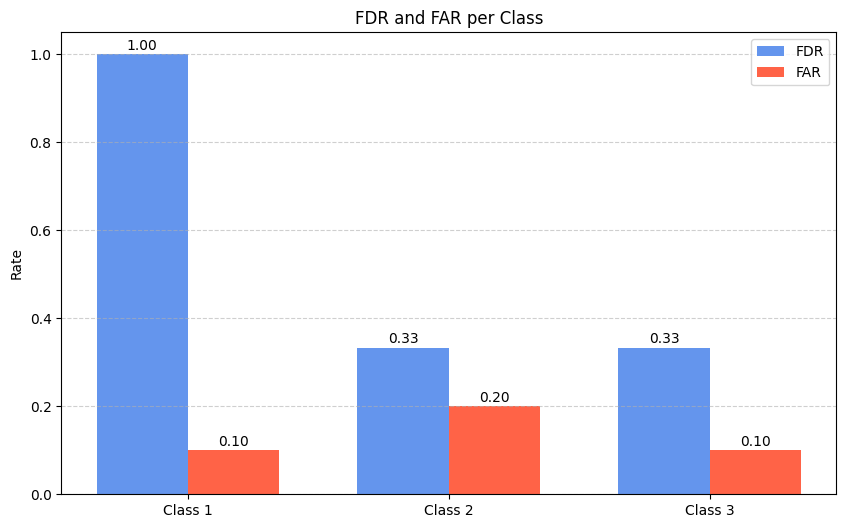

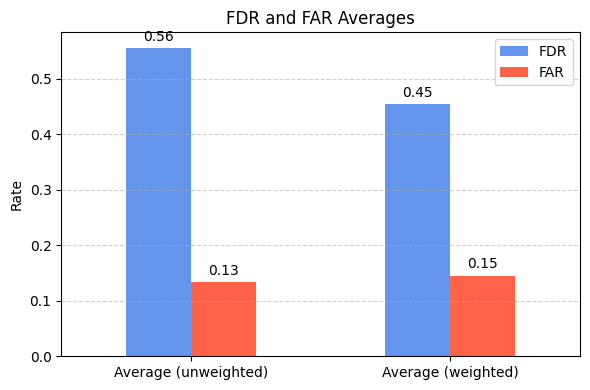

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_fdr_far(df: pd.DataFrame) -> None:
    df_plot = df.drop(index=["Average (unweighted)", "Average (weighted)"], errors="ignore")
    avg_rows = df.loc[["Average (unweighted)", "Average (weighted)"], ["FDR", "FAR"]]

    x = range(len(df_plot))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar([i - width/2 for i in x], df_plot["FDR"], width, label="FDR", color="cornflowerblue")
    ax.bar([i + width/2 for i in x], df_plot["FAR"], width, label="FAR", color="tomato")

    ax.set_xticks(list(x))
    ax.set_xticklabels([f"Class {int(i)}" for i in df_plot.index])
    ax.set_ylabel("Rate")
    ax.set_title("FDR and FAR per Class")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Annotate values on bars
    for i in x:
        ax.text(i - width/2, df_plot["FDR"].iloc[i] + 0.01, f"{df_plot['FDR'].iloc[i]:.2f}", ha="center")
        ax.text(i + width/2, df_plot["FAR"].iloc[i] + 0.01, f"{df_plot['FAR'].iloc[i]:.2f}", ha="center")

    # Add summary bars for averages
    fig, ax2 = plt.subplots(figsize=(6, 4))
    avg_rows.plot(kind="bar", ax=ax2, color=["cornflowerblue", "tomato"])
    ax2.set_ylabel("Rate")
    ax2.set_title("FDR and FAR Averages")
    ax2.grid(axis="y", linestyle="--", alpha=0.6)
    ax2.set_xticklabels(avg_rows.index, rotation=0)
    for container in ax2.containers:
        ax2.bar_label(container, fmt="%.2f", padding=3)

    plt.tight_layout()
    plt.show()


plot_fdr_far(df_fdr_far)


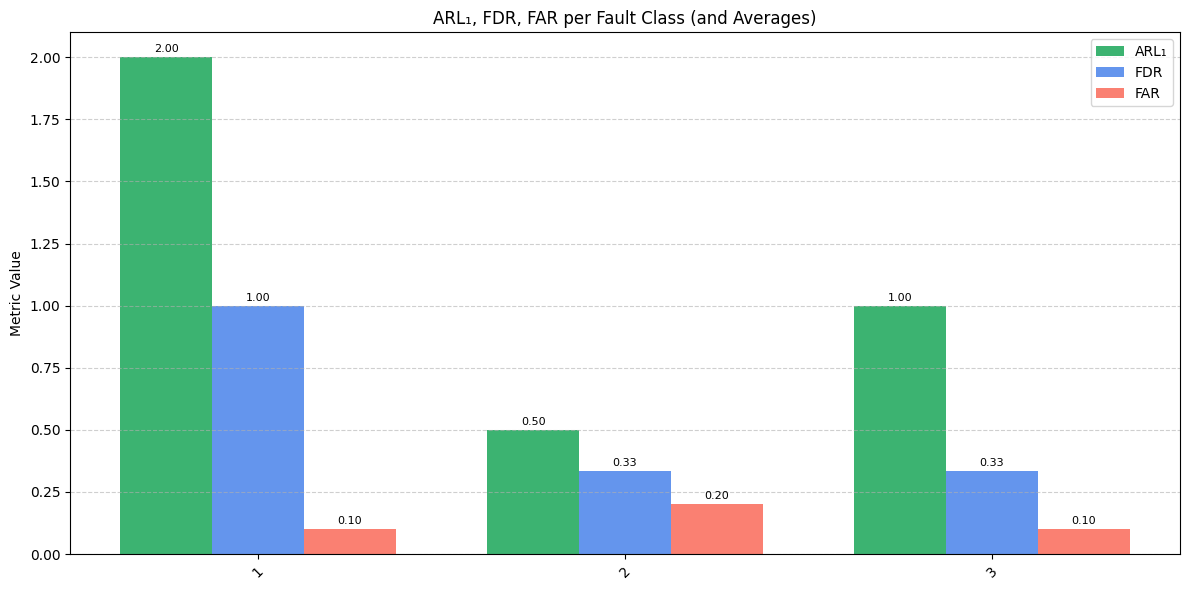

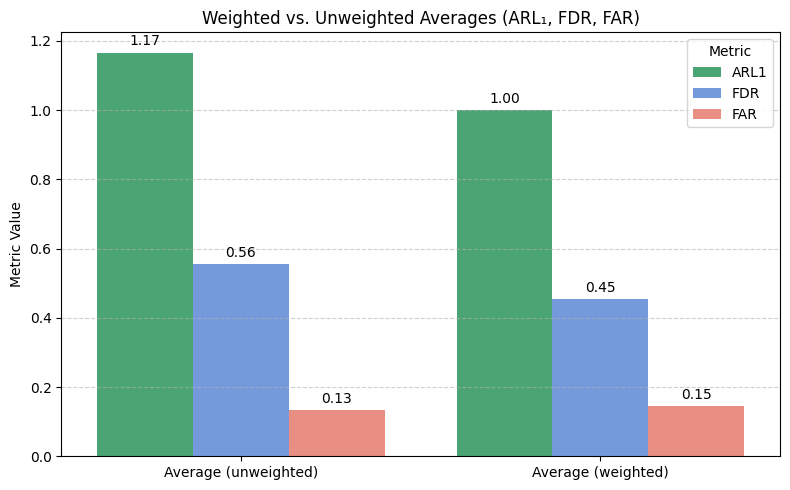

In [37]:
def combine_arl_fdr_far(df_arl: pd.DataFrame,
                        df_fdr_far: pd.DataFrame) -> pd.DataFrame:
    # Convert index to string for safe filtering
    df_arl.index = df_arl.index.map(str)
    df_fdr_far.index = df_fdr_far.index.map(str)

    # Filter out "Average" rows from both
    df_arl_main = df_arl[~df_arl.index.str.contains("Average")]
    df_fdr_far_main = df_fdr_far[~df_fdr_far.index.str.contains("Average")]

    # Join on class index
    df_combined = df_arl_main.join(df_fdr_far_main, how="outer")

    # Add average rows (now strings)
    avg_rows = pd.concat([
        df_arl[df_arl.index.str.contains("Average")],
        df_fdr_far[df_fdr_far.index.str.contains("Average")]
    ],
                         axis=0)

    return pd.concat([df_combined, avg_rows])


def plot_combined_per_fault(df: pd.DataFrame) -> None:
    df_plot = df.dropna(subset=["ARL1", "FDR", "FAR"])
    labels = df_plot.index.astype(str)

    x = range(len(df_plot))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar([i - width for i in x], df_plot["ARL1"], width, label="ARL₁", color="mediumseagreen")
    ax.bar([i for i in x], df_plot["FDR"], width, label="FDR", color="cornflowerblue")
    ax.bar([i + width for i in x], df_plot["FAR"], width, label="FAR", color="salmon")

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylabel("Metric Value")
    ax.set_title("ARL₁, FDR, FAR per Fault Class (and Averages)")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Annotate values
    for i, val in enumerate(x):
        for j, col in enumerate(["ARL1", "FDR", "FAR"]):
            y_val = df_plot.iloc[i][col]
            if pd.notna(y_val):
                ax.text(val + (j - 1) * width, y_val + 0.02, f"{y_val:.2f}", ha="center", fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_combined_averages(df: pd.DataFrame) -> None:
    df_avg = df.copy()
    df_avg.index = df_avg.index.map(str)

    # Filter only the two average rows
    df_avg = df_avg[df_avg.index.isin(
        ["Average (unweighted)", "Average (weighted)"])]
    df_avg = df_avg[["ARL1", "FDR", "FAR"]].dropna(how="all")

    df_avg = df_avg.rename_axis("Average Type").reset_index()
    df_melted = df_avg.melt(id_vars="Average Type",
                            var_name="Metric",
                            value_name="Value")

    # Create grouped bar plot
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_melted,
                     x="Average Type",
                     y="Value",
                     hue="Metric",
                     palette={
                         "ARL1": "mediumseagreen",
                         "FDR": "cornflowerblue",
                         "FAR": "salmon"
                     })

    ax.set_title("Weighted vs. Unweighted Averages (ARL₁, FDR, FAR)")
    ax.set_ylabel("Metric Value")
    ax.set_xlabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3)

    plt.tight_layout()
    plt.show()



df_arl = compute_arl_df(y_true, y_pred)
df_fdr_far = compute_fdr_far(y_true, y_pred)
df_combined = combine_arl_fdr_far(df_arl, df_fdr_far)

plot_combined_per_fault(df_combined)
plot_combined_averages(df_combined)




## 🔹 WHAT the Metrics Mean

### **1. ARL₁ (Average Run Length for Faults)**

* Definition: Expected number of time steps **after a fault starts** until it is detected.
* Low ARL₁ = **fast detection**
* High ARL₁ = **slow detection**

### **2. FDR (False Detection Rate)**

* Definition: Among all times the model predicted a specific fault (e.g. fault 2), how many were **wrong**.
* High FDR = **many predictions of fault 2 were incorrect** (i.e., mislabeling)
* FDR = FP / (TP + FP) per fault class

### **3. FAR (False Alarm Rate)**

* Definition: How often a fault class is **falsely predicted** during **normal operation** (i.e. when the true class is 0).
* Measures how noisy the model is during normal time.
* FAR = FP / (# total predicted faults during normal)

---

## 🔹 HOW They Relate

| Metric                                   | Condition                                                            | Interpretation                        |
| ---------------------------------------- | -------------------------------------------------------------------- | ------------------------------------- |
| **Low ARL₁** + **Low FDR** + **Low FAR** | Ideal                                                                | Fast and accurate detection, no noise |
| **Low ARL₁** + **High FDR**              | Fast detection, but many wrong fault predictions                     |                                       |
| **High ARL₁** + **Low FDR**              | Late detection, but when it happens, it's correct                    |                                       |
| **High FAR**                             | Model predicts faults during normal → false alarms                   |                                       |
| **High FDR** + **High FAR**              | Model often predicts faults, and often wrongly — unstable classifier |                                       |

---

## 🔹 HOW to Interpret the Plot

In your **combined plot**:

* Each bar group (per fault) shows:

  * **ARL₁:** How quickly the fault is detected
  * **FDR:** How often the predicted label for this fault was wrong
  * **FAR:** How noisy this fault label is during normal time

---

## 🔹 Example Interpretation

Say for **Fault 2**:

* ARL₁ = 0.5 → detected fast
* FDR = 0.3 → 30% of “Fault 2” predictions were incorrect
* FAR = 0.2 → Fault 2 was predicted during normal periods 20% of the time

**Interpretation**:

* Detection is quick (good),
* but 30% of the time the system thinks it's Fault 2, it's actually not (bad),
* and it's somewhat noisy during normal operation.

You'd ask:

* Can we improve the model to reduce false positives for Fault 2?
* Is the model too biased toward predicting Fault 2?

---

## 🔹 Summary Table

| Metric | Low is Good? | Meaning                   |
| ------ | ------------ | ------------------------- |
| ARL₁   | ✅            | Faster fault detection    |
| FDR    | ✅            | More precise labeling     |
| FAR    | ✅            | More stable during normal |

---

